## Approximating the `Sine` Function using a Classical Approach

We implement a classical Neural Network made up of three hidden layers to approximate the sine function. The purpose is to compare it with the QML version of the same approximator.

#### Create Datasets

In [1]:
import numpy as np

Discretize the interval of $[0, 2\pi]$ into a thousand points. Distribute them radomly into training and test datasets in 80:20 ratio. We use the test dataset to validate our trained model, to make sure it hasn't under/overfit the training data.

In [2]:
# preparation of input values in the range of [0, 2*pi)
values = np.linspace(0, 2*np.pi, 1000)

In [205]:
# random distribution of data into 80:20 ratio for train:test

sets = {'train': {'x': [], 'y': []}, 'test': {'x': [], 'y': []}}

for i in values:
    if np.random.rand() < 0.8:
        sets['train']['x'].append(i)
        sets['train']['y'].append(np.sin(i))
    else:
        sets['test']['x'].append(i)
        sets['test']['y'].append(np.sin(i))        

In [17]:
from torch.utils.data import DataLoader, Dataset

We use PyTorch to build the dataset and dataloaders that will be used during training and validation.

In [12]:
class sine_dataset(Dataset):
    
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [206]:
dataset_train = sine_dataset(sets['train']['x'], sets['train']['y'])
dataset_test = sine_dataset(sets['test']['x'], sets['test']['y'])

data_train = DataLoader(dataset_train, batch_size = 32, shuffle = True)
data_test = DataLoader(dataset_test, batch_size = 32, shuffle = True)

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F

After testing a few configurations of layers and number of neurons in each layer of the NN, we figured a configuration that works well in approximating the sine function. That is, we start with the input $x$, feed it to a hidden layer of 128 neurons. The next hidden layer is made up of 256 neurons, and the third one is made up of 128 again. 

Each layer is succeeded by a ReLU activation function. This provides the non-linearity to the network. The layer after is the output. Since the ReLU acitvation function has an output range of $[0, \infty]$, we also add an operation of $z = 2z-1$ at the end.

At the beginning of the operations in the network, we also divide the input by $\pi$ and subtract 1 from it to normalize the inputs into the interval of $[-1,1]$.

In [248]:
class SineApproximator(nn.Module):

    def __init__(self):
        super(SineApproximator, self).__init__()

        self.layer1 = nn.Linear(1, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 1)

    def forward(self, input):
        z = input/np.pi - 1
        z = self.layer1(z)
        z = F.relu(z)
        z = self.layer2(z)
        z = F.relu(z)
        z = self.layer3(z)
        z = F.relu(z)
        z = self.layer4(z)
        z = F.relu(z)
        output = 2*z - 1

        return output        

We use the inbuit MSELoss, i.e., Mean Squared Error Loss, provided by PyTorch, as the loss criterion. We also use a scheduler that drops the Learning Rate (LR) by a factor at a defined number of steps. This is for better approach to optimization, so that the Gradient Descent algorithm doesn't get stuck oscillating around a local optima due to a relatively larger LR when it could go to a better approximation of the local optima with a lower LR.

In [256]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

sine_func = SineApproximator()
criterion = nn.MSELoss()
optimizer = optim.Adam(sine_func.parameters(), lr = 0.0004)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)

sine_func.to(device)
num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0
    for inputs, targets in data_train:
        inputs = inputs.to(device).resize_(32,1)
        targets = targets.to(device).resize_(32,1)
        optimizer.zero_grad()
        outputs = sine_func(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss/len(data_train)
    if (epoch + 1) % 10 == 0: print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.8f}')

torch.save(sine_func, 'classical_nn.pt')

Epoch 10/100, Loss: 0.03207151
Epoch 20/100, Loss: 0.01672209
Epoch 30/100, Loss: 0.03553563
Epoch 40/100, Loss: 0.01779547
Epoch 50/100, Loss: 0.02248712
Epoch 60/100, Loss: 0.01766932
Epoch 70/100, Loss: 0.03469842
Epoch 80/100, Loss: 0.01589828
Epoch 90/100, Loss: 0.03456021
Epoch 100/100, Loss: 0.00553767


Post-training, let's check how the approximation is for a random number in the interval.

In [257]:
t = torch.Tensor([np.pi/6])
sine_func(t)

tensor([0.4835], grad_fn=<SubBackward0>)

The value of $0.4835$ is quite close enough to $\text{sin}(\pi/6)=0.5$.

We now compute the trained model's approximations for both train and test datasets, and plot them.

In [258]:
train_results = {'x': [], 'y': []}
test_results = {'x': [], 'y': []}

for inputs, _ in data_train:
    inputs = inputs.to(device).resize_(32,1)
    res = sine_func(inputs)
    for i in range(32):
        train_results['x'].append(inputs[i].item())
        train_results['y'].append(res[i].item())

for inputs, _ in data_test:
    inputs = inputs.to(device).resize_(32,1)
    res = sine_func(inputs)
    for i in range(32):
        test_results['x'].append(inputs[i].item())
        test_results['y'].append(res[i].item())

In [152]:
import matplotlib.pyplot as plt

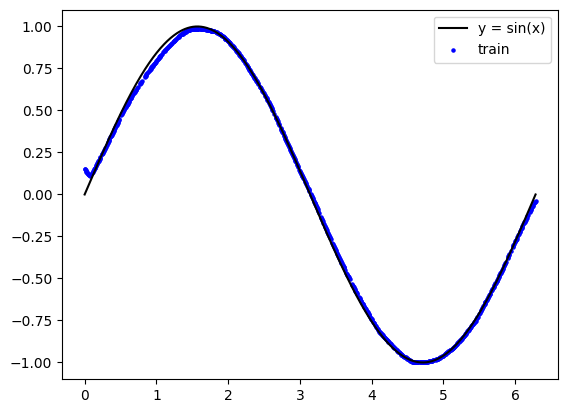

In [268]:
plt.plot(values, np.sin(values), color = 'black', label = 'y = sin(x)')
plt.scatter(train_results['x'], train_results['y'], color = 'blue', label = 'train', s = 5)
plt.legend()
plt.show()

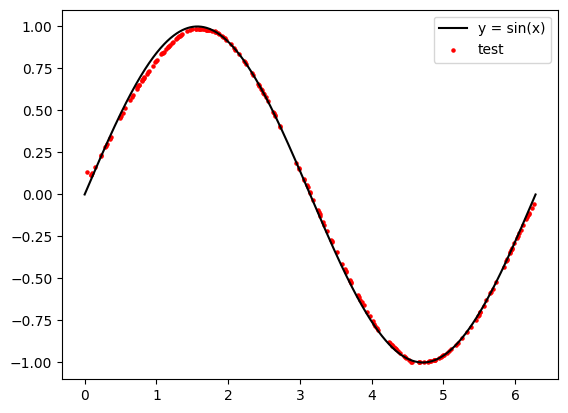

In [267]:
plt.plot(values, np.sin(values), color = 'black', label = 'y = sin(x)')
plt.scatter(test_results['x'], test_results['y'], color = 'red', label = 'test', s = 5)
plt.legend()
plt.show()

As we can see from the plots, the classical neural network approximates the sine function well enough.